In [1]:
import torch
from torch.utils import data
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import sklearn.datasets
import time
import matplotlib.pyplot as plt
import numpy as np
import wandb
import copy
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
class Timer:
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        self.tik = time.time()

    def stop(self):
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        return sum(self.times) / len(self.times)

    def sum(self):
        return sum(self.times)

In [3]:
class MLP(nn.Module):
    def __init__(self, num_classes=2):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(2, 10, bias=True)
        init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='leaky_relu')
        self.fc2 = nn.Linear(10, 8, bias=True)
        init.kaiming_normal_(self.fc2.weight, mode='fan_in', nonlinearity='leaky_relu')
        self.fc3 = nn.Linear(8, 4, bias=True)
        init.kaiming_normal_(self.fc3.weight, mode='fan_in', nonlinearity='leaky_relu')
        self.fc4 = nn.Linear(4, num_classes, bias=True)
        init.xavier_uniform_(self.fc4.weight, )


    def forward(self, x):
        out = self.fc1(x)
        out = F.leaky_relu(out)
        out = self.fc2(out)
        out = F.leaky_relu(out)
        out = self.fc3(out)
        out = F.leaky_relu(out)
        out = self.fc4(out)
        return out


class QuantizeLayer(nn.Module):
    def __init__(self, layer):
        super(QuantizeLayer, self).__init__()
        self.layer = layer

    def forward(self, x):
        if isinstance(self.layer, nn.Conv2d):
            weight_q = torch.sign(self.layer.weight)
            if self.layer.bias is not None:
                bias_q = torch.sign(self.layer.bias)
                return nn.functional.conv2d(
                    x,
                    weight_q,
                    bias_q,
                    self.layer.stride,
                    self.layer.padding,
                    self.layer.dilation,
                    self.layer.groups,
                )
            else:
                return nn.functional.conv2d(
                    x,
                    weight_q,
                    None,
                    self.layer.stride,
                    self.layer.padding,
                    self.layer.dilation,
                    self.layer.groups,
                )
        elif isinstance(self.layer, nn.Linear):
            weight_q = torch.sign(self.layer.weight)
            if self.layer.bias is not None:
                bias_q = torch.sign(self.layer.bias)
                return nn.functional.linear(x, weight_q, bias_q)
            else:
                return nn.functional.linear(x, weight_q, None)
        else:
            return self.layer(x)

In [4]:
def MLP2MoonsNet():
    return MLP(num_classes=2)

In [5]:
# def sgda(params, y, lrx, lry, batch_size):
#     with torch.no_grad():
#         for param in params:
#             param -= lrx * param.grad / batch_size
#             param.grad.zero_()
#         y -= lry * y.grad / batch_size
#         y.grad.zero_()
#         y = torch.where(y < 0, 0, y)

In [6]:
def load_array(features, labels, batch_size, is_train=True):
    dataset = data.TensorDataset(features, labels)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [7]:
def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

In [8]:
def plot(X_train, X_test, Y_train, Y_test, width=600):
    fig, ax = plt.subplots(1, 1, figsize=set_size(width))
    ax.scatter(
        X_train[:, 0],
        X_train[:, 1],
        s=30,
        c=Y_train,
        cmap=plt.cm.Spectral,
    )
    ax.scatter(
        X_test[:, 0],
        X_test[:, 1],
        s=20,
        color="black",
        cmap=plt.cm.Spectral,
    )
    ax.plot()
    # fig.savefig("twomoonsdataset.pdf", format="pdf", bbox_inches="tight")

In [9]:
def plotcontour(net, X_train, X_test, Y_train, Y_test, width=600):
    fig, ax = plt.subplots(1, 1, figsize=set_size(width))
    min1=-2
    max1=3
    min2=-1.5
    max2=1.75

    x1grid = np.arange(min1, max1, 0.01)
    x2grid = np.arange(min2, max2, 0.01)
    xx, yy = np.meshgrid(x1grid, x2grid)
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    grid = np.hstack((r1,r2))
    outputs = net(torch.tensor(grid, device=device, dtype=torch.float))
    zz= F.softmax(outputs, 1)[:,1]
    _, predicted = torch.max(F.softmax(net(torch.tensor(X_test, dtype=torch.float, device=device)), 1), 1)
    correct = (predicted.cpu()==Y_test)
    color = ["white" if correct[i] else "black" for i in range(Y_test.shape[0])]
    zz = zz.reshape(xx.shape).cpu().detach().numpy()
    c=ax.contourf(xx, yy, zz, 200, cmap='RdBu', vmin=0, vmax=1)
    ax.contour(xx, yy, zz, levels=[0.5], color='k', linewidths=2)
    fig.colorbar(c)
    ax.scatter(
        X_train[:, 0],
        X_train[:, 1],
        s=30,
        c=Y_train,
        cmap=plt.cm.Spectral,
    )
    ax.scatter(
        X_test[:, 0],
        X_test[:, 1],
        s=20,
        c=color,
        cmap=plt.cm.Spectral,
    )
    fig.savefig("twomoonsdb2.pdf", format="pdf", bbox_inches="tight")

In [10]:
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import argparse
import os

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set hyperparameter
EPOCH = 60
ANNEAL_EPOCH = 30
pre_epoch = 0
BATCH_SIZE = 200
LR = 0.5
alpha = 0.2
method = "ASkewSGD"
# method = "SGD"

# Generate training and testing dataset
n_train = 2000
n_test = 500
n = n_train + n_test
X, Y = sklearn.datasets.make_moons(n_samples=n, noise=0.1, random_state=0)
X = torch.from_numpy(X).float()
Y = torch.from_numpy(Y).reshape(-1)
X_train, Y_train = X[:n_train], Y[:n_train]
X_test, Y_test = X[n_train:], Y[n_train:]
trainloader = load_array(X_train, Y_train, batch_size=BATCH_SIZE, is_train=True)
testloader = load_array(X_test, Y_test, batch_size=BATCH_SIZE, is_train=False)

# Define base net
base_net = MLP2MoonsNet().to(device)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hokfong (hokfong-the-chinese-university-of-hong-kong). Use `wandb login --relogin` to force relogin



Epoch: 1
[epoch:1, iter:1] Loss: 0.755 | Acc: 48.500% 
[epoch:1, iter:2] Loss: 2.936 | Acc: 49.750% 
[epoch:1, iter:3] Loss: 2.350 | Acc: 47.333% 
[epoch:1, iter:4] Loss: 2.082 | Acc: 48.500% 
[epoch:1, iter:5] Loss: 1.776 | Acc: 49.200% 
[epoch:1, iter:6] Loss: 1.567 | Acc: 45.167% 
[epoch:1, iter:7] Loss: 1.443 | Acc: 45.929% 
[epoch:1, iter:8] Loss: 1.320 | Acc: 46.250% 
[epoch:1, iter:9] Loss: 1.212 | Acc: 46.722% 
[epoch:1, iter:10] Loss: 1.129 | Acc: 46.950% 
Waiting Test...
Test's accuracy (before quantization) is: 90.000%
Test's accuracy (after quantization) is: 47.800%

Epoch: 2
[epoch:2, iter:11] Loss: 0.598 | Acc: 50.000% 
[epoch:2, iter:12] Loss: 0.600 | Acc: 47.750% 
[epoch:2, iter:13] Loss: 0.556 | Acc: 47.833% 
[epoch:2, iter:14] Loss: 0.501 | Acc: 48.250% 
[epoch:2, iter:15] Loss: 0.474 | Acc: 49.800% 
[epoch:2, iter:16] Loss: 0.471 | Acc: 50.333% 
[epoch:2, iter:17] Loss: 0.435 | Acc: 50.643% 
[epoch:2, iter:18] Loss: 0.409 | Acc: 50.875% 
[epoch:2, iter:19] Loss: 0.3

loss,██▃▂▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
quantized loss,▆▅▂▃█▇▃▃▃▁▁▁▂▂▂▃▂▂▂▃▃▂▂▃▃▃▂▃▃▂▂▃▂▂▂▃▂▃▃▂
loss,3e-05
quantized loss,0.59982


C:\Users\Administrator\AppData\Local\Temp\ipykernel_17048\4061754191.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _, predicted = torch.max(F.softmax(net(torch.tensor(X_test, dtype=torch.float, device=device)), 1), 1)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_17048\4061754191.py:21: UserWarning: The following kwargs were not used by contour: 'color'
  ax.contour(xx, yy, zz, levels=[0.5], color='k', linewidths=2)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_17048\4061754191.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
C:\Users\Administrator\AppData\Local\Temp\ipykernel_17048\4061754191.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rat

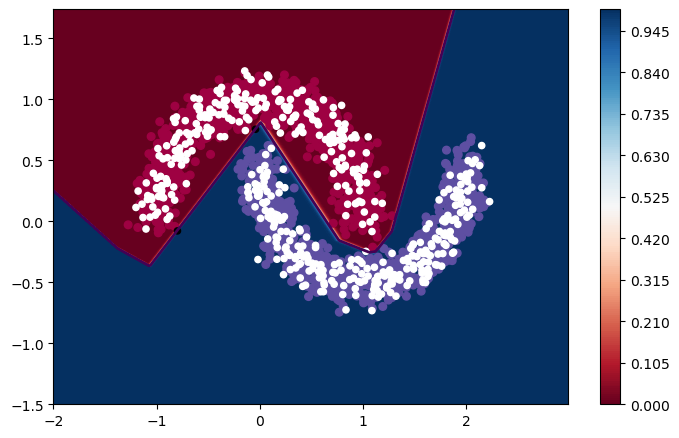

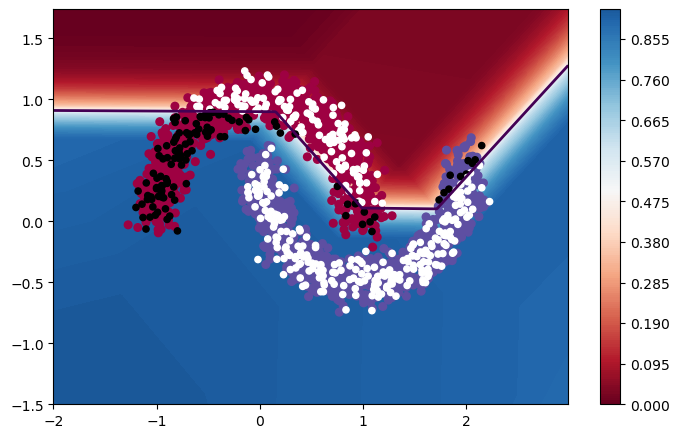

In [11]:
# SGD
wandb.init(
    # set the wandb project where this run will be logged
    project="exp2 (W1-A32)",
    name="SGD",
    # track hyperparameters and run metadata
    config={
        "batch_size": 200,
        "architecture": "MLP",
        "dataset": "TwoMoons",
        "lr": 0.5,
        "alpha": 0.2,
    },
)

# Define neural network
net = copy.deepcopy(base_net)

# Define loss funtion & optimizer
criterion = nn.CrossEntropyLoss()
weights = [p for name, p in net.named_parameters() if 'bias' not in name]
bias = [p for name, p in net.named_parameters() if 'bias' in name]
parameters = [{"params": weights, "tag": "weights"}, {"params": bias, "tag": "bias"}]
optimizer = optim.Adam(parameters, lr=LR, betas=(0.9, 0.999))
lr_decay_epochs = [15, 25]
for decay_epoch in lr_decay_epochs:
    if pre_epoch > decay_epoch:
        for param_group in optimizer.param_groups:
            param_group["lr"] *= 0.5

# Train
for epoch in range(pre_epoch, EPOCH):
    print("\nEpoch: %d" % (epoch + 1))
    net.train()
    sum_loss = 0.0
    correct = 0.0
    total = 0.0
    epsilon = 100

    if epoch in lr_decay_epochs:
        for param_group in optimizer.param_groups:
            param_group["lr"] *= 0.5

    for i, data in enumerate(trainloader, 0):
        # prepare dataset
        length = len(trainloader)
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # forward & backward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        model_copy = copy.deepcopy(net)
        with torch.no_grad():
            for name, param in model_copy.named_parameters():
                if not name.endswith(".bias"):
                    param.data = torch.sign(param.data)
        outputs = model_copy(inputs)
        loss2 = criterion(outputs, labels)
        wandb.log(
            {
                "quantized loss": loss2,
                "loss": loss,
            }
        )
        for param_group in optimizer.param_groups:
            if param_group["tag"] == "weights" and method == "ASkewSGD":
                for idx, p in enumerate(param_group["params"]):
                    constr = epsilon - (p.data**2 - 1) ** 2
                    Kx = -4 * (p.data**2 - 1) * p.data
                    direct_grad = torch.logical_or(
                        torch.logical_or(constr >= 0, Kx == 0),
                        torch.logical_and(
                            constr < 0, (-Kx * p.grad.data) >= -alpha * constr
                        ),
                    )
                    p.grad.data[direct_grad] = p.grad.data[direct_grad]
                    p.grad.data[~direct_grad] = torch.clip(
                        alpha * constr / Kx,
                        -2 / param_group["lr"],
                        2 / param_group["lr"],
                    )[~direct_grad]
        optimizer.step()
        optimizer.zero_grad()
        sum_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels.data).cpu().sum()
        print(
            "[epoch:%d, iter:%d] Loss: %.03f | Acc: %.3f%% "
            % (
                epoch + 1,
                (i + 1 + (epoch) * length),
                sum_loss / (i + 1),
                100.0 * correct / total,
            )
        )
    print("Waiting Test...")
    with torch.no_grad():
        correct = 0
        total = 0
        for data in testloader:
            net.eval()
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()
        print(
            "Test's accuracy (before quantization) is: %.3f%%" % (100 * correct / total)
        )
    model_copy = copy.deepcopy(net)
    with torch.no_grad():
        for name, param in model_copy.named_parameters():
            if not name.endswith(".bias"):
                param.data = torch.sign(param.data)
        correct = 0
        total = 0
        for data in testloader:
            model_copy.eval()
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model_copy(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()
        print(
            "Test's accuracy (after quantization) is: %.3f%%" % (100 * correct / total)
        )
wandb.finish()
plotcontour(net, X_train, X_test, Y_train, Y_test)
model_copy = copy.deepcopy(net)
for name, param in model_copy.named_parameters():
    if not name.endswith(".bias"):
        param.data = torch.sign(param.data)
plotcontour(model_copy, X_train, X_test, Y_train, Y_test)


Epoch: 1
[epoch:1, iter:1] Loss: 0.755 | Acc: 51.000% 
[epoch:1, iter:2] Loss: 2.952 | Acc: 52.000% 
[epoch:1, iter:3] Loss: 2.301 | Acc: 57.167% 
[epoch:1, iter:4] Loss: 1.883 | Acc: 54.250% 
[epoch:1, iter:5] Loss: 1.606 | Acc: 56.900% 
[epoch:1, iter:6] Loss: 1.412 | Acc: 59.667% 
[epoch:1, iter:7] Loss: 1.292 | Acc: 60.500% 
[epoch:1, iter:8] Loss: 1.180 | Acc: 61.375% 
[epoch:1, iter:9] Loss: 1.121 | Acc: 60.833% 
[epoch:1, iter:10] Loss: 1.045 | Acc: 62.300% 
Waiting Test...
Test's accuracy (before quantization) is: 75.200%
Test's accuracy (after quantization) is: 78.000%

Epoch: 2
[epoch:2, iter:11] Loss: 0.501 | Acc: 75.500% 
[epoch:2, iter:12] Loss: 0.429 | Acc: 73.250% 
[epoch:2, iter:13] Loss: 0.402 | Acc: 72.500% 
[epoch:2, iter:14] Loss: 0.367 | Acc: 72.750% 
[epoch:2, iter:15] Loss: 0.369 | Acc: 73.200% 
[epoch:2, iter:16] Loss: 0.360 | Acc: 73.250% 
[epoch:2, iter:17] Loss: 0.361 | Acc: 74.143% 
[epoch:2, iter:18] Loss: 0.367 | Acc: 74.500% 
[epoch:2, iter:19] Loss: 0.3

loss,█▇▅▃▂▄▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
quantized loss,█▄▂▁▁▁▂▁▁▂▁▁▁▁▂▇▆▇▇▇█▇▇▇▇▇▇▇▇▇▆▇▇▆▇▆▇▇▇▇
loss,0.02705
quantized loss,2.461


C:\Users\Administrator\AppData\Local\Temp\ipykernel_17048\4061754191.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _, predicted = torch.max(F.softmax(net(torch.tensor(X_test, dtype=torch.float, device=device)), 1), 1)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_17048\4061754191.py:21: UserWarning: The following kwargs were not used by contour: 'color'
  ax.contour(xx, yy, zz, levels=[0.5], color='k', linewidths=2)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_17048\4061754191.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
C:\Users\Administrator\AppData\Local\Temp\ipykernel_17048\4061754191.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rat

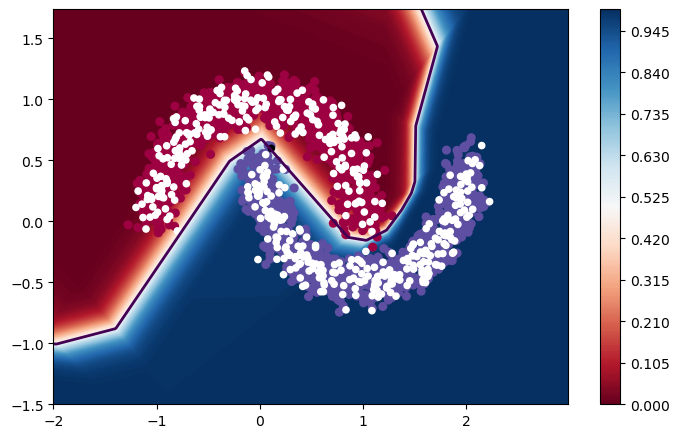

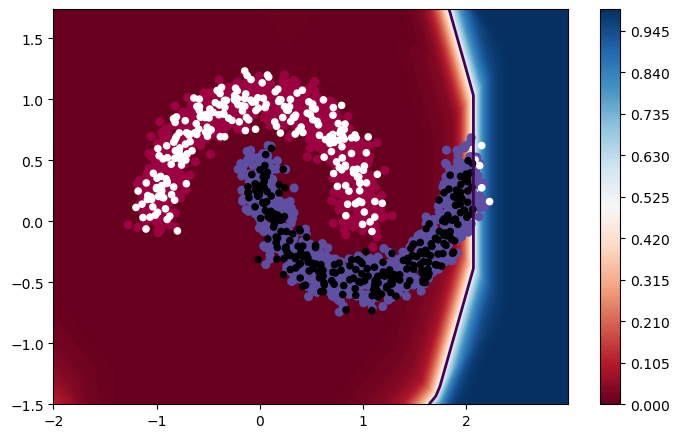

In [14]:
# SGD Controlled
wandb.init(
    # set the wandb project where this run will be logged
    project="exp2 (W1-A32)",
    name="SGDc",
    # track hyperparameters and run metadata
    config={
        "batch_size": 200,
        "architecture": "MLP",
        "dataset": "TwoMoons",
        "lr": 0.5,
        "alpha": 0.2,
    },
)

# Define neural network
net = copy.deepcopy(base_net)

# Define loss funtion & optimizer
criterion = nn.CrossEntropyLoss()
weights = [p for name, p in net.named_parameters() if 'bias' not in name]
bias = [p for name, p in net.named_parameters() if 'bias' in name]
parameters = [{"params": weights, "tag": "weights"}, {"params": bias, "tag": "bias"}]
optimizer = optim.Adam(parameters, lr=LR, betas=(0.9, 0.999))
lr_decay_epochs = [15, 25]
for decay_epoch in lr_decay_epochs:
    if pre_epoch > decay_epoch:
        for param_group in optimizer.param_groups:
            param_group["lr"] *= 0.5

# Train
for epoch in range(pre_epoch, EPOCH):
    print("\nEpoch: %d" % (epoch + 1))
    net.train()
    sum_loss = 0.0
    correct = 0.0
    total = 0.0
    epsilon = 1

    if epoch in lr_decay_epochs:
        for param_group in optimizer.param_groups:
            param_group["lr"] *= 0.5

    for i, data in enumerate(trainloader, 0):
        # prepare dataset
        length = len(trainloader)
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # forward & backward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        model_copy = copy.deepcopy(net)
        with torch.no_grad():
            for name, param in model_copy.named_parameters():
                if not name.endswith(".bias"):
                    param.data = torch.sign(param.data)
        outputs = model_copy(inputs)
        loss2 = criterion(outputs, labels)
        wandb.log(
            {
                "quantized loss": loss2,
                "loss": loss,
            }
        )
        for param_group in optimizer.param_groups:
            if param_group["tag"] == "weights" and method == "ASkewSGD":
                for idx, p in enumerate(param_group["params"]):
                    constr = epsilon - (p.data**2 - 1) ** 2
                    Kx = -4 * (p.data**2 - 1) * p.data
                    direct_grad = torch.logical_or(
                        torch.logical_or(constr >= 0, Kx == 0),
                        torch.logical_and(
                            constr < 0, (-Kx * p.grad.data) >= -alpha * constr
                        ),
                    )
                    p.grad.data[direct_grad] = p.grad.data[direct_grad]
                    p.grad.data[~direct_grad] = torch.clip(
                        alpha * constr / Kx,
                        -2 / param_group["lr"],
                        2 / param_group["lr"],
                    )[~direct_grad]
        optimizer.step()
        optimizer.zero_grad()
        sum_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels.data).cpu().sum()
        print(
            "[epoch:%d, iter:%d] Loss: %.03f | Acc: %.3f%% "
            % (
                epoch + 1,
                (i + 1 + (epoch) * length),
                sum_loss / (i + 1),
                100.0 * correct / total,
            )
        )
    print("Waiting Test...")
    with torch.no_grad():
        correct = 0
        total = 0
        for data in testloader:
            net.eval()
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()
        print(
            "Test's accuracy (before quantization) is: %.3f%%" % (100 * correct / total)
        )
    model_copy = copy.deepcopy(net)
    with torch.no_grad():
        for name, param in model_copy.named_parameters():
            if not name.endswith(".bias"):
                param.data = torch.sign(param.data)
        correct = 0
        total = 0
        for data in testloader:
            model_copy.eval()
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model_copy(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()
        print(
            "Test's accuracy (after quantization) is: %.3f%%" % (100 * correct / total)
        )
wandb.finish()
plotcontour(net, X_train, X_test, Y_train, Y_test)
model_copy = copy.deepcopy(net)
for name, param in model_copy.named_parameters():
    if not name.endswith(".bias"):
        param.data = torch.sign(param.data)
plotcontour(model_copy, X_train, X_test, Y_train, Y_test)


Epoch: 1
[epoch:1, iter:1] Loss: 0.792 | Acc: 51.500% 
[epoch:1, iter:2] Loss: 0.811 | Acc: 50.750% 
[epoch:1, iter:3] Loss: 0.749 | Acc: 49.333% 
[epoch:1, iter:4] Loss: 0.691 | Acc: 56.625% 
[epoch:1, iter:5] Loss: 0.641 | Acc: 61.300% 
[epoch:1, iter:6] Loss: 0.599 | Acc: 63.167% 
[epoch:1, iter:7] Loss: 0.557 | Acc: 65.143% 
[epoch:1, iter:8] Loss: 0.522 | Acc: 66.812% 
[epoch:1, iter:9] Loss: 0.514 | Acc: 67.944% 
[epoch:1, iter:10] Loss: 0.501 | Acc: 69.150% 
Waiting Test...
Test's accuracy (before quantization) is: 86.600%
Test's accuracy (after quantization) is: 81.600%

Epoch: 2
[epoch:2, iter:11] Loss: 0.354 | Acc: 79.500% 
[epoch:2, iter:12] Loss: 0.361 | Acc: 76.000% 
[epoch:2, iter:13] Loss: 0.322 | Acc: 78.833% 
[epoch:2, iter:14] Loss: 0.319 | Acc: 78.750% 
[epoch:2, iter:15] Loss: 0.322 | Acc: 78.500% 
[epoch:2, iter:16] Loss: 0.329 | Acc: 78.083% 
[epoch:2, iter:17] Loss: 0.327 | Acc: 78.357% 
[epoch:2, iter:18] Loss: 0.325 | Acc: 78.562% 
[epoch:2, iter:19] Loss: 0.3

loss,▆█▄▃▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
quantized loss,▃▃▄▃▃▅▅▇▇▆▆▆▇▆█▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.00367
quantized loss,0.00514


C:\Users\Administrator\AppData\Local\Temp\ipykernel_17048\4061754191.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _, predicted = torch.max(F.softmax(net(torch.tensor(X_test, dtype=torch.float, device=device)), 1), 1)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_17048\4061754191.py:21: UserWarning: The following kwargs were not used by contour: 'color'
  ax.contour(xx, yy, zz, levels=[0.5], color='k', linewidths=2)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_17048\4061754191.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
C:\Users\Administrator\AppData\Local\Temp\ipykernel_17048\4061754191.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rat

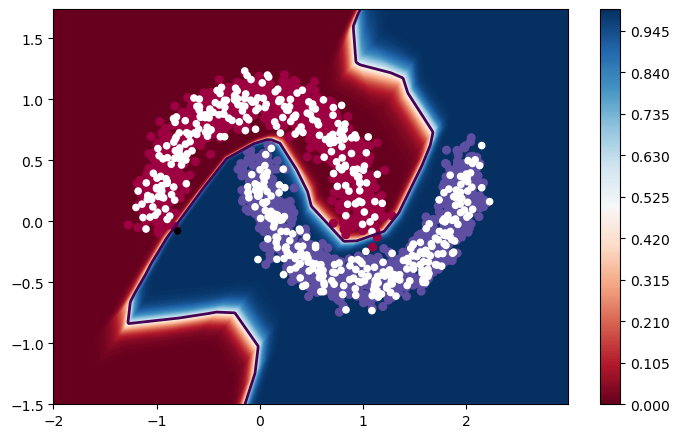

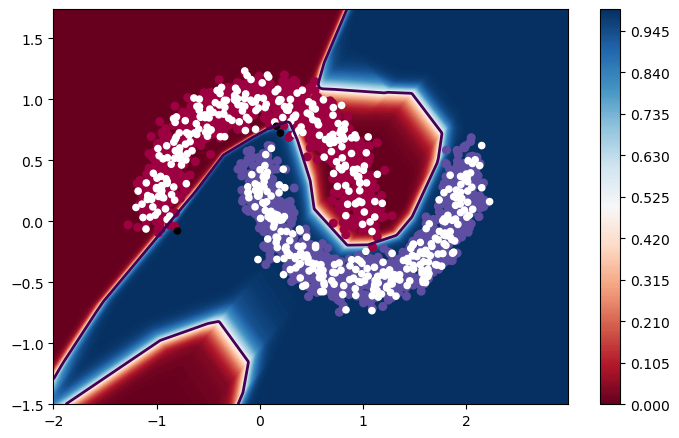

In [15]:
# ASkewSGD
wandb.init(
    # set the wandb project where this run will be logged
    project="exp2 (W1-A32)",
    name="ASkewSGD",
    # track hyperparameters and run metadata
    config={
        "batch_size": 200,
        "architecture": "MLP",
        "dataset": "TwoMoons",
        "lr": 0.166,
        "alpha": 0.2,
    },
)

# Define neural network
net = copy.deepcopy(base_net)

# Define loss funtion & optimizer
criterion = nn.CrossEntropyLoss()
weights = [p for name, p in net.named_parameters() if 'bias' not in name]
bias = [p for name, p in net.named_parameters() if 'bias' in name]
parameters = [{"params": weights, "tag": "weights"}, {"params": bias, "tag": "bias"}]
optimizer = optim.Adam(parameters, lr=LR/3, betas=(0.9, 0.999))
lr_decay_epochs = [15, 25]
for decay_epoch in lr_decay_epochs:
    if pre_epoch > decay_epoch:
        for param_group in optimizer.param_groups:
            param_group["lr"] *= 0.5

# Train
for epoch in range(pre_epoch, EPOCH):
    print("\nEpoch: %d" % (epoch + 1))
    net.train()
    sum_loss = 0.0
    correct = 0.0
    total = 0.0
    if epoch < ANNEAL_EPOCH:
        epsilon = 1
    else:
        epsilon = 0.88 ** (epoch - ANNEAL_EPOCH)

    if epoch in lr_decay_epochs:
        for param_group in optimizer.param_groups:
            param_group["lr"] *= 0.5

    for i, data in enumerate(trainloader, 0):
        # prepare dataset
        length = len(trainloader)
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # forward & backward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        model_copy = copy.deepcopy(net)
        with torch.no_grad():
            for name, param in model_copy.named_parameters():
                if not name.endswith(".bias"):
                    param.data = torch.sign(param.data)
        outputs = model_copy(inputs)
        loss2 = criterion(outputs, labels)
        wandb.log(
            {
                "quantized loss": loss2,
                "loss": loss,
            }
        )
        for param_group in optimizer.param_groups:
            if param_group["tag"] == "weights" and method == "ASkewSGD":
                for idx, p in enumerate(param_group["params"]):
                    constr = epsilon - (p.data**2 - 1) ** 2
                    Kx = -4 * (p.data**2 - 1) * p.data
                    direct_grad = torch.logical_or(
                        torch.logical_or(constr >= 0, Kx == 0),
                        torch.logical_and(
                            constr < 0, (-Kx * p.grad.data) >= -alpha * constr
                        ),
                    )
                    p.grad.data[direct_grad] = p.grad.data[direct_grad]
                    p.grad.data[~direct_grad] = torch.clip(
                        alpha * constr / Kx,
                        -20 / param_group["lr"],
                        20 / param_group["lr"],
                    )[~direct_grad]
        optimizer.step()
        optimizer.zero_grad()
        sum_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels.data).cpu().sum()
        print(
            "[epoch:%d, iter:%d] Loss: %.03f | Acc: %.3f%% "
            % (
                epoch + 1,
                (i + 1 + (epoch) * length),
                sum_loss / (i + 1),
                100.0 * correct / total,
            )
        )
    print("Waiting Test...")
    with torch.no_grad():
        correct = 0
        total = 0
        for data in testloader:
            net.eval()
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()
        print(
            "Test's accuracy (before quantization) is: %.3f%%" % (100 * correct / total)
        )
    model_copy = copy.deepcopy(net)
    with torch.no_grad():
        for name, param in model_copy.named_parameters():
            if not name.endswith(".bias"):
                param.data = torch.sign(param.data)
        correct = 0
        total = 0
        for data in testloader:
            model_copy.eval()
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model_copy(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()
        print(
            "Test's accuracy (after quantization) is: %.3f%%" % (100 * correct / total)
        )
wandb.finish()
plotcontour(net, X_train, X_test, Y_train, Y_test)
model_copy = copy.deepcopy(net)
for name, param in model_copy.named_parameters():
    if not name.endswith(".bias"):
        param.data = torch.sign(param.data)
plotcontour(model_copy, X_train, X_test, Y_train, Y_test)


Epoch: 1
[epoch:1, iter:1] Loss: 3.642 | Acc: 48.500% 
[epoch:1, iter:2] Loss: 7.135 | Acc: 47.750% 
[epoch:1, iter:3] Loss: 5.005 | Acc: 49.833% 
[epoch:1, iter:4] Loss: 3.928 | Acc: 49.500% 
[epoch:1, iter:5] Loss: 3.333 | Acc: 49.700% 
[epoch:1, iter:6] Loss: 2.954 | Acc: 51.917% 
[epoch:1, iter:7] Loss: 2.689 | Acc: 53.571% 
[epoch:1, iter:8] Loss: 2.441 | Acc: 55.938% 
[epoch:1, iter:9] Loss: 2.246 | Acc: 57.944% 
[epoch:1, iter:10] Loss: 2.074 | Acc: 59.350% 
Waiting Test...
Test's accuracy (before quantization) is: 47.400%
Test's accuracy (after quantization) is: 73.600%

Epoch: 2
[epoch:2, iter:11] Loss: 0.541 | Acc: 73.000% 
[epoch:2, iter:12] Loss: 0.554 | Acc: 72.500% 
[epoch:2, iter:13] Loss: 0.608 | Acc: 65.500% 
[epoch:2, iter:14] Loss: 0.643 | Acc: 60.875% 
[epoch:2, iter:15] Loss: 0.660 | Acc: 59.000% 
[epoch:2, iter:16] Loss: 0.674 | Acc: 57.500% 
[epoch:2, iter:17] Loss: 0.739 | Acc: 51.857% 
[epoch:2, iter:18] Loss: 0.703 | Acc: 55.125% 
[epoch:2, iter:19] Loss: 0.6

loss,▃▃▃▄█▄▃▂▃▂▂▂▃▄▄▅▇▅▅▅▅▅▅▄▃▆▄▃▄▄▃▃▃▃▃▂▂▁▁▂
quantized loss,██▄▂█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.57799
quantized loss,0.03261


C:\Users\Administrator\AppData\Local\Temp\ipykernel_17048\4061754191.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _, predicted = torch.max(F.softmax(net(torch.tensor(X_test, dtype=torch.float, device=device)), 1), 1)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_17048\4061754191.py:21: UserWarning: The following kwargs were not used by contour: 'color'
  ax.contour(xx, yy, zz, levels=[0.5], color='k', linewidths=2)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_17048\4061754191.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
C:\Users\Administrator\AppData\Local\Temp\ipykernel_17048\4061754191.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rat

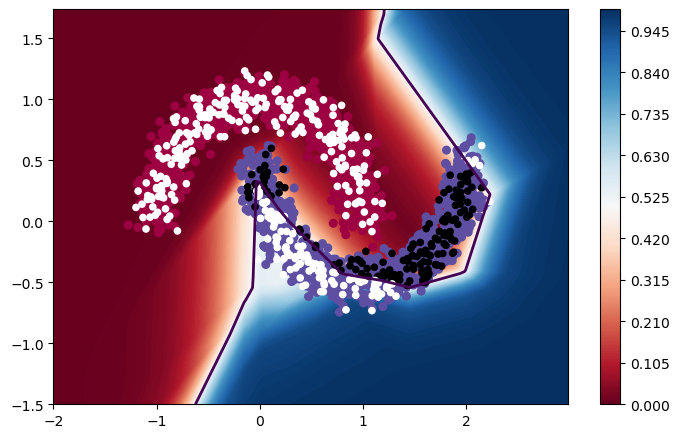

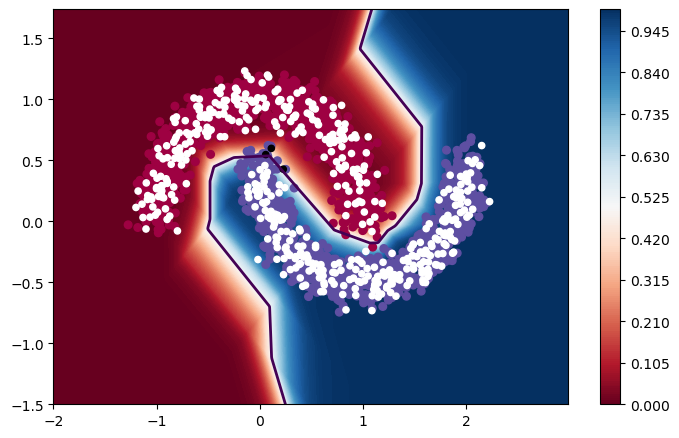

In [20]:
# Deterministic BinaryConnect
wandb.init(
    # set the wandb project where this run will be logged
    project="exp2 (W1-A32)",
    name="Deterministic BinaryConnect",
    # track hyperparameters and run metadata
    config={
        "batch_size": 200,
        "architecture": "MLP",
        "dataset": "TwoMoons",
        "lr": 0.05,
    },
)

# Define neural network
net = copy.deepcopy(base_net)
model_copy = copy.deepcopy(net)
model_copy.eval()

# Define loss funtion & optimizer
criterion = nn.CrossEntropyLoss()
weights = [p for name, p in net.named_parameters() if 'bias' not in name]
bias = [p for name, p in net.named_parameters() if 'bias' in name]
parameters = [{"params": weights, "tag": "weights"}, {"params": bias, "tag": "bias"}]
optimizer = optim.Adam(parameters, lr=LR/10, betas=(0.9, 0.999))
lr_decay_epochs = [15, 25]
for decay_epoch in lr_decay_epochs:
    if pre_epoch > decay_epoch:
        for param_group in optimizer.param_groups:
            param_group["lr"] *= 0.5

# Train
for epoch in range(pre_epoch, EPOCH):
    print("\nEpoch: %d" % (epoch + 1))
    net.train()
    sum_loss = 0.0
    correct = 0.0
    total = 0.0

    if epoch in lr_decay_epochs:
        for param_group in optimizer.param_groups:
            param_group["lr"] *= 0.5

    for i, data in enumerate(trainloader, 0):
        # prepare dataset
        length = len(trainloader)
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # forward & backward
        with torch.no_grad():
            outputs = model_copy(inputs)
            loss2 = criterion(outputs, labels)
            for net_name, net_param in net.named_parameters():
                if not net_name.endswith(".bias"):
                    net_param.data = torch.sign(net_param.data)
            
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        wandb.log(
            {
                "quantized loss": loss,
                "loss": loss2,
            }
        )
        optimizer.step()
        optimizer.zero_grad()
        with torch.no_grad():
            for (net_name, net_param), (model_copy_name, model_copy_param) in zip(net.named_parameters(), model_copy.named_parameters()):
                if not net_name.endswith(".bias"):
                    # print(net_name, net_param)
                    # print(model_copy_name, model_copy_param)
                    delta = net_param.data-torch.sign(model_copy_param.data)
                    net_param.data = torch.clamp(model_copy_param.data + delta, -1, 1)
                model_copy_param.data=net_param.data
        sum_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels.data).cpu().sum()
        print(
            "[epoch:%d, iter:%d] Loss: %.03f | Acc: %.3f%% "
            % (
                epoch + 1,
                (i + 1 + (epoch) * length),
                sum_loss / (i + 1),
                100.0 * correct / total,
            )
        )
    print("Waiting Test...")
    with torch.no_grad():
        correct = 0
        total = 0
        for data in testloader:
            net.eval()
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()
        print(
            "Test's accuracy (before quantization) is: %.3f%%" % (100 * correct / total)
        )
    net_copy = copy.deepcopy(net)
    with torch.no_grad():
        for name, param in net_copy.named_parameters():
            if not name.endswith(".bias"):
                param.data = torch.sign(param.data)
        correct = 0
        total = 0
        for data in testloader:
            net_copy.eval()
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net_copy(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()
        print(
            "Test's accuracy (after quantization) is: %.3f%%" % (100 * correct / total)
        )
wandb.finish()
plotcontour(net, X_train, X_test, Y_train, Y_test)
net_copy = copy.deepcopy(net)
for name, param in net_copy.named_parameters():
    if not name.endswith(".bias"):
        param.data = torch.sign(param.data)
plotcontour(net_copy, X_train, X_test, Y_train, Y_test)


Epoch: 1
[epoch:1, iter:1] Loss: 6.576 | Acc: 50.500% 
[epoch:1, iter:2] Loss: 3.700 | Acc: 53.250% 
[epoch:1, iter:3] Loss: 2.804 | Acc: 43.500% 
[epoch:1, iter:4] Loss: 3.401 | Acc: 45.250% 
[epoch:1, iter:5] Loss: 2.886 | Acc: 45.500% 
[epoch:1, iter:6] Loss: 2.678 | Acc: 42.167% 
[epoch:1, iter:7] Loss: 2.643 | Acc: 38.214% 
[epoch:1, iter:8] Loss: 2.421 | Acc: 40.125% 
[epoch:1, iter:9] Loss: 2.275 | Acc: 40.167% 
[epoch:1, iter:10] Loss: 2.126 | Acc: 40.800% 
Waiting Test...
Test's accuracy (after quantization) is: 14.400%

Epoch: 2
[epoch:2, iter:11] Loss: 0.726 | Acc: 52.500% 
[epoch:2, iter:12] Loss: 0.717 | Acc: 50.250% 
[epoch:2, iter:13] Loss: 0.712 | Acc: 49.500% 
[epoch:2, iter:14] Loss: 0.699 | Acc: 56.250% 
[epoch:2, iter:15] Loss: 0.697 | Acc: 57.600% 
[epoch:2, iter:16] Loss: 0.692 | Acc: 56.833% 
[epoch:2, iter:17] Loss: 0.692 | Acc: 55.857% 
[epoch:2, iter:18] Loss: 0.664 | Acc: 57.812% 
[epoch:2, iter:19] Loss: 0.669 | Acc: 56.833% 
[epoch:2, iter:20] Loss: 0.670 

quantized loss,█▆▆▆▄▄▃▃▄▃▃▂▂▄▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
quantized loss,0.07554


C:\Users\Administrator\AppData\Local\Temp\ipykernel_17048\4061754191.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _, predicted = torch.max(F.softmax(net(torch.tensor(X_test, dtype=torch.float, device=device)), 1), 1)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_17048\4061754191.py:21: UserWarning: The following kwargs were not used by contour: 'color'
  ax.contour(xx, yy, zz, levels=[0.5], color='k', linewidths=2)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_17048\4061754191.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(


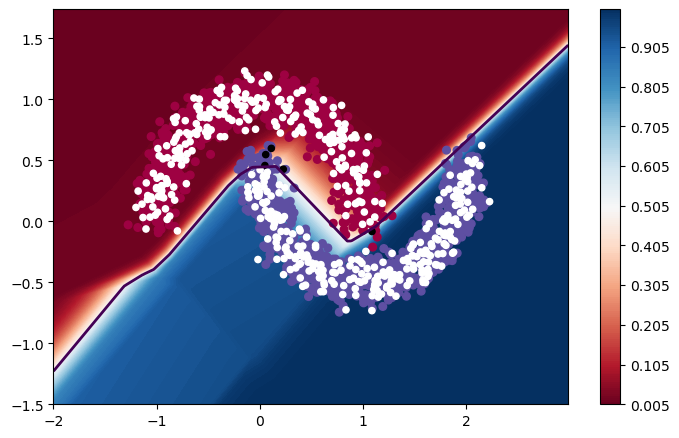

In [29]:
# Stochastic BinaryConnect
wandb.init(
    # set the wandb project where this run will be logged
    project="exp2 (W1-A32)",
    name="Stochastic BinaryConnect",
    # track hyperparameters and run metadata
    config={
        "batch_size": 200,
        "architecture": "MLP",
        "dataset": "TwoMoons",
        "lr": 0.166,
    },
)

# Define neural network
net = copy.deepcopy(base_net)
model_copy = copy.deepcopy(net)
model_copy.eval()

# Define loss funtion & optimizer
criterion = nn.CrossEntropyLoss()
weights = [p for name, p in net.named_parameters() if 'bias' not in name]
bias = [p for name, p in net.named_parameters() if 'bias' in name]
parameters = [{"params": weights, "tag": "weights"}, {"params": bias, "tag": "bias"}]
optimizer = optim.Adam(parameters, lr=LR/3, betas=(0.9, 0.999))
lr_decay_epochs = [15, 25]
for decay_epoch in lr_decay_epochs:
    if pre_epoch > decay_epoch:
        for param_group in optimizer.param_groups:
            param_group["lr"] *= 0.5

# Train
for epoch in range(pre_epoch, EPOCH):
    print("\nEpoch: %d" % (epoch + 1))
    net.train()
    sum_loss = 0.0
    correct = 0.0
    total = 0.0

    if epoch in lr_decay_epochs:
        for param_group in optimizer.param_groups:
            param_group["lr"] *= 0.5

    for i, data in enumerate(trainloader, 0):
        # prepare dataset
        length = len(trainloader)
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # forward & backward
        with torch.no_grad():
            for net_name, net_param in net.named_parameters():
                if not net_name.endswith(".bias"):
                    net_param.data = (torch.bernoulli(F.hardsigmoid(net_param.data*3))-0.5)*2
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        wandb.log(
            {
                "quantized loss": loss,
            }
        )
        
        with torch.no_grad():
            for param_group in optimizer.param_groups:
                if param_group["tag"] == "weights":
                    for idx, p in enumerate(param_group["params"]):
                        p.data = torch.fill(p, 0)
        optimizer.step()

        with torch.no_grad():
            for (net_name, net_param), (model_copy_name, model_copy_param) in zip(net.named_parameters(), model_copy.named_parameters()):
                if not net_name.endswith(".bias"):
                    delta = net_param.data
                    net_param.data = model_copy_param.data + delta
                model_copy_param.data = net_param.data

        optimizer.zero_grad()
        sum_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels.data).cpu().sum()
        print(
            "[epoch:%d, iter:%d] Loss: %.03f | Acc: %.3f%% "
            % (
                epoch + 1,
                (i + 1 + (epoch) * length),
                sum_loss / (i + 1),
                100.0 * correct / total,
            )
        )
    print("Waiting Test...")
    net_copy = copy.deepcopy(net)
    with torch.no_grad():
        for name, param in net_copy.named_parameters():
            if not name.endswith(".bias"):
                param.data = (torch.bernoulli(F.hardsigmoid(param.data*3))-0.5)*2

        correct = 0
        total = 0
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net_copy(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()
        print(
            "Test's accuracy (after quantization) is: %.3f%%" % (100 * correct / total)
        )
wandb.finish()
model_copy = copy.deepcopy(net)
for name, param in model_copy.named_parameters():
    if not name.endswith(".bias"):
       param.data = (torch.bernoulli(F.hardsigmoid(param.data*3))-0.5)*2
plotcontour(model_copy, X_train, X_test, Y_train, Y_test)